# CRR Binomial Model Overview

The Cox-Ross-Rubinstein model is a binomial tree model used to price options. For an American put option, the holder has the right (but not the obligation) to sell a stock at a specified strike price prior to or at the expiration of the option. In this model, the stock price at each node can move up or down by factors $ u $ (up factor) and $ d $ (down factor). The Risk-free Rate Parameter $ R $ affects the discounting of expected future payoffs.


### Variables:
- $ S_0 $: Initial stock price
- $ u $: Upward movement factor
- $ d $: Downward movement factor
- $ R $: Risk-free Rate Parameter (1 + risk-free interest rate)
- $ K $: Strike price of the put option
- $ T $: Number of periods (time steps)

### Steps to Compute the Option Price:
1. **Build the stock price tree**: Starting with $ S_0 $, compute the possible stock prices at each node for $ T $ periods.
2. **Calculate the option value at expiration**: The value of an American put option at expiry is $ \max(K - S, 0) $ for each possible stock price.
3. **Backward induction**: For each node starting from the last but one to the first:
   - Calculate the present value of expected payoff of holding the option (considering the value of option when stock price moves up and moves down).
   - Calculate the value of exercising the option (i.e., $ \max(K - S, 0) $).
   - The value at each node is the maximum of these two values.

### Result:
The root of the tree provides the arbitrage-free price of the American put option.


# Implementation and an Example

Consider a CRR model with $T = 2$, $S_0 = \$100$, $S_1 = \$300$ or $S_1 = \$50$, and with risk free interest rate parameter $R = 1.2$. Consider a American call option based on the stock in the CRR model that has strike price $K=\$110$ 

Create a function to compute the arbitrage free pricing of an American put option where $S_0, u, d, R, K, T$ are variables and use the function to check your answer.

In [1]:
# import necessary package here
import numpy as np

In [2]:
# Specify/Compute the parameter values (S0, u, d, R, K, T)
S0 = 100
K = 110
u = 3   # Upward movement factor
d = 0.5   # Downward movement factor
R = 1.2  # Risk-free interest rate per period
T = 3     # Time to expiration in periods

In [3]:
# write a function for American put option pricing
def American_put_option_pricing(S0, u, d, R, K, T):
    """Compute the pricing of an American put option
    --------------------------------------------------------------------------
    Input:
        S0: initial stock price (at time 0)
        u: up factor
        d: down factor
        R: risk free interest rate
        K: strike price
        T: time to maturity
    Output:
        arbitrage free initial price of the American put option at time zero
        (a value)
    """

    # Calculate the risk-neutral probability
    q = (R - d) / (u - d)
    
    # Initialize the binomial price tree: Calculating the stock price paths
    prices = np.zeros((T + 1, T + 1))
    for i in range(T + 1):
        for j in range(i + 1):
            prices[j, i] = S0 * (u ** j) * (d ** (i - j))

    
    # Calculating the final value of option at t = T
    option_values = np.zeros((T + 1, T + 1))
    for i in range(T + 1):
        option_values[i, T] = max(0, K - prices[i, T])
    
    # Backward induction to find the option value at each node
    for i in range(T - 1, -1, -1):
        for j in range(i + 1):
            exercise = K - prices[j, i]
            continue_option = (q * option_values[j + 1, i + 1] + (1 - q) * option_values[j, i + 1]) / R
            option_values[j, i] = max(exercise, continue_option)
    
    # Return the option value at the root of the tree
    return option_values[0, 0], option_values, prices

In [4]:
option_value,  option_values_path, stock_prices = American_put_option_pricing(S0, u, d, R , K, T)#2

In [5]:
option_value

38.94

# Visualizing the process

In [6]:
import pandas as pd

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

In [8]:
G = nx.DiGraph()

n = len(stock_prices)

# q: risk-neutral probability
q = (R - d) / (u - d)

# Create nodes for stock prices
for i in range(n ):
    for j in range(i+1):
        stock_price = stock_prices[j, i]
        G.add_node((i, j), stock_price = stock_price)
        #print(i," ", j)
        #print(stock_prices[j, i])
        intrinsic_value = max(0, K - stock_price)
        G.nodes[(i, j)]['intrinsic_value'] = intrinsic_value
        
        G.nodes[(i, j)]['option_value'] = option_values_path[j, i]

###
# Create edges and define transition factors

for i in range(n-1):
    for j in range(i +1):
        G.add_edge((i, j), (i + 1, j + 1), weight=u)
        G.add_edge((i, j), (i + 1 , j ), weight=d)

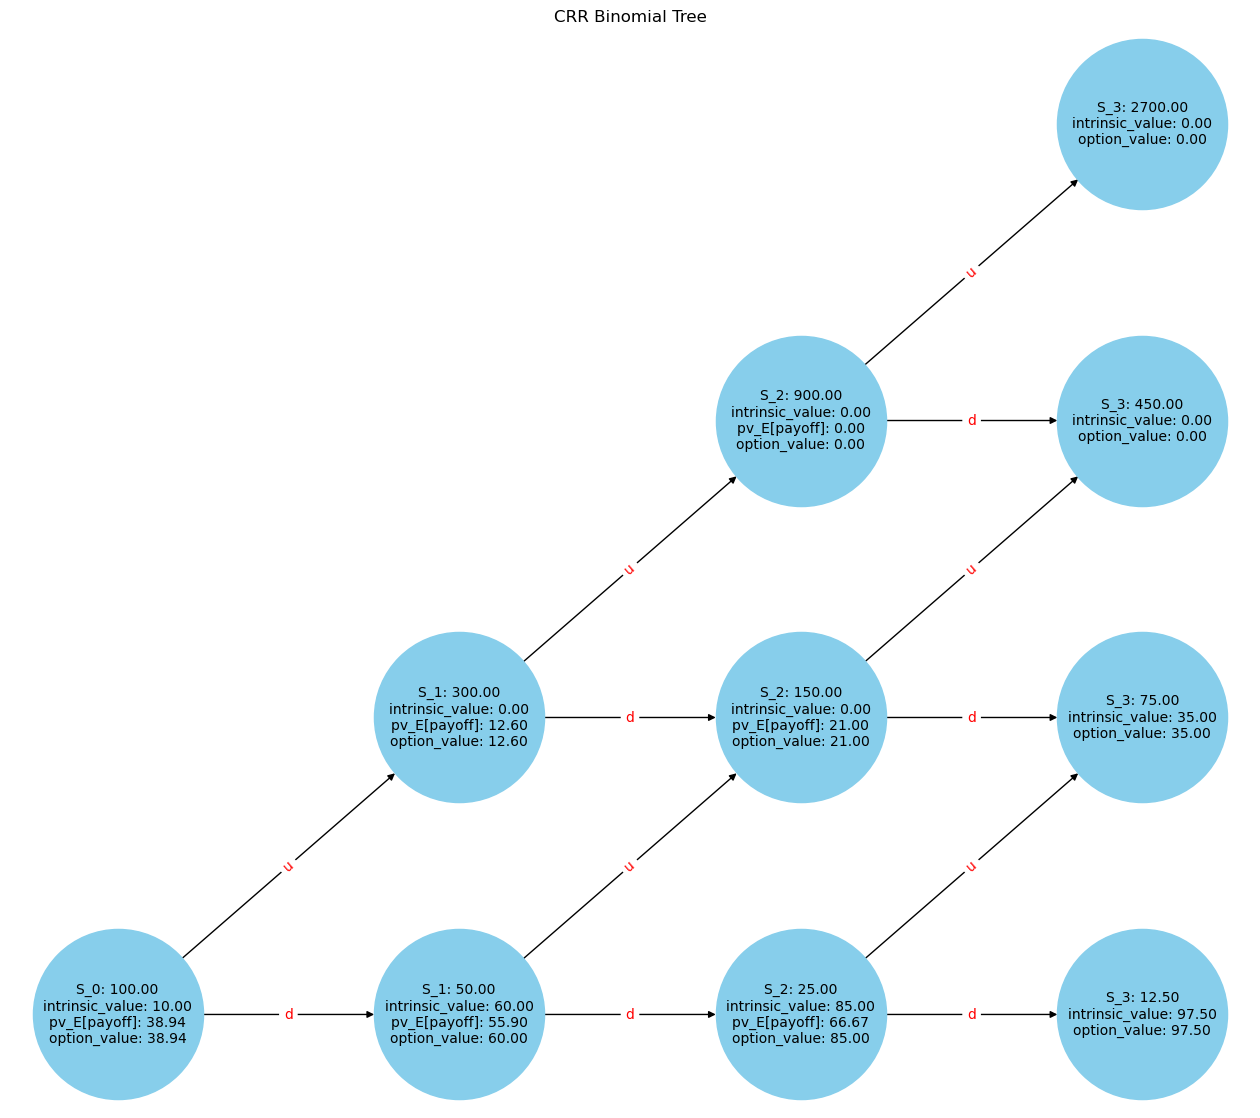

In [9]:
#########
pos = {}
labels = {}
for i in range(n ):
    for j in range(i+1):
        pos[(i, j)] = (i, j)
        if i != n-1:
            #if now is not maturity time
            labels[(i, j)] = (f"S_{i}: {G.nodes[(i, j)]['stock_price']:.2f}\n"
                             f"intrinsic_value: {G.nodes[(i, j)]['intrinsic_value']:.2f}\n"
                             f"pv_E[payoff]: {((q * option_values_path[j + 1, i + 1] + (1 - q) * option_values_path[j, i + 1]) / R):.2f}\n"
                             f"option_value: {G.nodes[(i, j)]['option_value']:.2f}")
            
        else:
            #if now is maturity time
            labels[(i, j)] = (f"S_{i}: {G.nodes[(i, j)]['stock_price']:.2f}\n"
                             f"intrinsic_value: {G.nodes[(i, j)]['intrinsic_value']:.2f}\n"
                             f"option_value: {G.nodes[(i, j)]['option_value']:.2f}")
        
fig, ax = plt.subplots(figsize=(16, 14))
nx.draw(G, pos, ax=ax, with_labels=True, labels=labels, node_size=15000, node_color='skyblue', font_size=10)

###

edge_labels = {edge: f"{'d' if edge[1][1] == edge[0][1] else 'u'}" for edge in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

###


plt.title(f"CRR Binomial Tree")
plt.savefig('bionomial_tree.png')
plt.show()

In [19]:
# an example showcase how in time 2 and stock price path = dd, pv_E[payoff] is calculated
((q * 35 + (1 - q) * 97.5) / R)

66.66666666666667